# 1.Fuction import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner as gridliner
import datetime
import calendar 
import sys
import os
import glob
import gsw
import json
import time
# Add the current directory to the system path
sys.path.append('/g/data/jk72/zc0441')
# from clef.code import *
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
from zpackage import wmt
from zpackage.zclef import Zlook,Zsearch
from zpackage.colormap import cmap_br

In [6]:
# model = 'ACCESS-CM2' 		 ## 'ACCESS-CM2' 'ACCESS-ESM1-5' 'CAS-ESM2-0' 'CanESM5' 'FIO-ESM-2-0' 'CNRM-CM6-1' 'FGOALS-g3' 'IPSL-CM6A-LR' 'CMCC-CM2-HR4' 'EC-Earth3'
variable_list = ['tos', 'sos', 'hfds', 'wfo' ,'vmo', 'so' ,'thetao']
# variable_list_si = [ 'siconc','sidmassdyn','sidmassth'] # 'sispeed'
variable_list_si = [ 'siconc','sidmassth'] # 'sispeed'
variable_list_si_dyn = [ 'siconc','sidmassdyn']
variable_list_si_fsi = [ 'siconc','fsitherm']

frequency = ['mon']
experiment = ['historical']
member_id = ['r1i1p1f1', 'r1i1p1f2'] # , 'r11i1p1f1'
realm = ['ocean']
grid_label = ['gn']

season_name = ['DJF', 'MAM', 'JJA', 'SON'] # The names of season for seasonal averaging
yrst = '1990'; yren = '1999'
lat_edge = -45

figure_save_trigger = False # True #
data_save_trigger =  False # False #True #
file_path = '/g/data/jk72/zc0441/Subject_1/model_list.json'
fig_path = '/g/data/jk72/zc0441/Figures/20230913/'


In [3]:
constraint = {'variable_id': variable_list,'frequency': frequency, 'realm': realm ,'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
constraint_si = {'variable_id': variable_list_si,'frequency': frequency, 'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
constraint_si_dyn = {'variable_id': variable_list_si_dyn,'frequency': frequency, 'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
constraint_si_fsi = {'variable_id': variable_list_si_fsi,'frequency': frequency, 'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
df = Zsearch(constraint)
df_si = Zsearch(constraint_si)
df_si_dyn = Zsearch(constraint_si_dyn)
df_si_fsi = Zsearch(constraint_si_fsi)

In [4]:
model_list = ['ACCESS-CM2',
             'ACCESS-ESM1-5',
             'CNRM-CM6-1',
             'CNRM-CM6-1-HR',
             'CNRM-ESM2-1',
             'EC-Earth3',
             'EC-Earth3-AerChem',
             'EC-Earth3-CC',
             'FGOALS-f3-L',
             'FGOALS-g3',
             'IPSL-CM6A-LR',
             'IPSL-CM6A-LR-INCA',
             'MIROC6',
             'NorESM2-LM',
             'NorESM2-MM',
             'UKESM1-0-LL']


model_list_si = ['ACCESS-CM2',
                 'ACCESS-ESM1-5',
                 'CNRM-CM6-1',
                 'CNRM-CM6-1-HR',
                 'CNRM-ESM2-1',
                 'EC-Earth3',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'IPSL-CM6A-LR',
                 'IPSL-CM6A-LR-INCA',
                 'NorESM2-LM',
                 'NorESM2-MM',
                 'UKESM1-0-LL']

model_list_si_dyn = ['CNRM-CM6-1',
                    'CNRM-CM6-1-HR',
                    'CNRM-ESM2-1',
                    'UKESM1-0-LL']

model_list_si_fsi = ['ACCESS-ESM1-5',
                    'EC-Earth3']
model_list = ['ACCESS-CM2',
             'ACCESS-ESM1-5',
             'CMCC-CM2-SR5',
             'CMCC-ESM2',
             'EC-Earth3',
             'EC-Earth3-AerChem',
             'EC-Earth3-CC',
             'IPSL-CM6A-LR',
             'IPSL-CM6A-LR-INCA',
             'MIROC6',
             'MPI-ESM-1-2-HAM',
             'MPI-ESM1-2-HR',
             'MPI-ESM1-2-LR',
             'MRI-ESM2-0',
             'NorESM2-LM',
             'NorESM2-MM']
len(model_list)

16

In [7]:
%%time
for model in model_list[0:1]:
    file_paths = df.variable_paths(model) # allocate the file paths

    # select avaliable data for the model
    # if model in model_list_si_dyn:
    #     file_paths_si = df_si_dyn.variable_paths(model)
    #     variable_list_si = [ 'siconc','sidmassdyn']
    # elif model in model_list_si_fsi:
    #     file_paths_si = df_si_fsi.variable_paths(model)
    #     variable_list_si = [ 'siconc','fsitherm']
    # else:
    #     file_paths_si = df_si.variable_paths(model)
    #     variable_list_si = [ 'siconc','sidmassth']
    file_paths_si = df_si_fsi.variable_paths(model)
    variable_list_si = [ 'siconc','fsitherm']
    
    # add a flag for model UKESM1-0-LL, cause the cell area data saved in different experiment
    if 'UKESM1' in model:  
        df_ga = Zlook({'variable': 'areacello', 'model': model}) # The sea grid area 
    else:
        df_ga = Zlook({'variable': 'areacello', 'model': model, 'experiment': 'historical' ,'grid_label': 'gn'}) # The sea grid area 

    grid_area = xr.open_dataset(df_ga.kw_search(df_ga.path(),'1')[0])[df_ga.v()] # allocate the data 

    ## Find the coord key for model
    dim_list = list(grid_area.dims)+ list(grid_area.coords.keys())
    lat_key = None
    lon_key = None
    lat_keys = ['latitude', 'lat', 'nav_lat']
    lon_keys = ['longitude', 'lon', 'nav_lon']
    j_keys = ['y','j']
    i_keys = ['x','i']
    for key in dim_list:

        if key in lat_keys:
            lat_key = key
        if key in lon_keys:
            lon_key = key
        if key in j_keys:
            j_key = key
        if key in i_keys:
            i_key = key
            
    # 2D coordinate data loading
    tem = xr.open_mfdataset(file_paths[0]+'/*.nc', combine='by_coords', parallel=True)[variable_list[0]].sel(time = slice(yrst, yren))
    sal = xr.open_mfdataset(file_paths[1]+'/*.nc', combine='by_coords', parallel=True)[variable_list[1]].sel(time = slice(yrst, yren))
    hf = xr.open_mfdataset(file_paths[2]+'/*.nc', combine='by_coords', parallel=True)[variable_list[2]].sel(time = slice(yrst, yren))           
    fwf = xr.open_mfdataset(file_paths[3]+'/*.nc', combine='by_coords', parallel=True)[variable_list[3]].sel(time = slice(yrst, yren))
    mty = xr.open_mfdataset(file_paths[4]+'/*.nc', combine='by_coords', parallel=True)[variable_list[4]].sel(time = slice(yrst, yren))
    sic = xr.open_mfdataset(file_paths_si[0]+'/*.nc', combine='by_coords', parallel=True)[variable_list_si[0]].sel(time = slice(yrst, yren))
    sith = xr.open_mfdataset(file_paths_si[1]+'/*.nc', combine='by_coords', parallel=True)[variable_list_si[1]].sel(time = slice(yrst, yren))

    pre =0

    # Search the grid along the selected latitude boundary
    latitude = mty[lat_key].values
    nearest_index = np.abs(latitude - lat_edge).argmin(axis=0)
    if isinstance(nearest_index, np.ndarray): # In case the nearest_index is a list
        nearest_index = nearest_index[0]

    # 3D coordinate data
    # Select the salinity and temperature along the selected latitude
    sal_raw = xr.open_mfdataset(file_paths[5]+'/*.nc', combine='by_coords', parallel=True)[variable_list[5]][:,:,nearest_index,:].sel(time = slice(yrst, yren))
    tem_raw = xr.open_mfdataset(file_paths[6]+'/*.nc', combine='by_coords', parallel=True)[variable_list[6]][:,:,nearest_index,:].sel(time = slice(yrst, yren))  #.sel(**{j_key : nearest_index, 'time' : slice(yrst, yren)}).
    pre_raw = 0

    # The heat flux and freshwater flux direction check
    hf_dir_check_sample = hf.sel(time = yrst + '-07').where(hf[lat_key]>30).mean()
    fwf_dir_check_sample = fwf.sel(time = yrst + '-07').where(fwf[lat_key]>50).mean()
    sith_dir_check_sample = sith.sel(time = yrst + '-07').where(sith[lat_key]>-70).mean()

    if hf_dir_check_sample < 0:
        hf = -hf
    if fwf_dir_check_sample < 0:
        fwf = -fwf
    if sith_dir_check_sample <0:
        sith = -sith
    ### The grid is 
    hf_mean = hf.where(hf[lat_key]<lat_edge).groupby('time.season').mean('time').compute()
    fwf_mean = fwf.where(fwf[lat_key]<lat_edge).groupby('time.season').mean('time').compute()
    sal_mean = sal.where(sal[lat_key]<lat_edge).groupby('time.season').mean('time').compute()
    tem_mean = tem.where(tem[lat_key]<lat_edge).groupby('time.season').mean('time').compute()
    sic_mean = sic.where(sic[lat_key]<lat_edge).groupby('time.season').mean('time').compute()
    sith_mean = sith.where(sith[lat_key]<lat_edge).groupby('time.season').mean('time').compute()

    sal_ver = sal_raw.groupby('time.season').mean('time').compute()
    tem_ver = tem_raw.groupby('time.season').mean('time').compute()
    #=== Only for 'NorESM2' model, whose sea ice grid is differ from ocean grid
    if 'NorESM2' in model:
        # Select the unique values 
        hf_mean = hf_mean[:,:-1,:]
        fwf_mean = fwf_mean[:,:-1,:]
        sal_mean = sal_mean[:,:-1,:]
        tem_mean = tem_mean[:,:-1,:]                         
    # calculate the total transportation within the boundary
    mt = mty[:,:,nearest_index,:].groupby('time.season').mean('time').compute()
    den_ver = gsw.rho(sal_ver,tem_ver,0)
    tr = mt/den_ver
    
    sic_sep_mean = sic.sel(time=sic['time.month'] == 9).mean(dim='time')
    sic_sep_mean = sic_sep_mean.where(sic_sep_mean[lat_key]<lat_edge) ## The max sea ice extent

        
    ##====Only for the FGOALS models, where the sea ice grid is reversied ====##
    if 'FGOALS' in model:
        sith_mean_m = sith_mean.loc[dict(j=slice(None, None, -1))]
        sith_mean = xr.DataArray(sith_mean_m, coords=fwf_mean.coords, dims=fwf_mean.dims)
    
    pre_mean = 0
    density_mean = gsw.rho(sal_mean, tem_mean, pre_mean)

    tr_heat_weighted = wmt.trans_rate_heat(hf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    tr_fwf_weighted = wmt.trans_rate_water(fwf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    tr_sith_weighted = wmt.trans_rate_seaice(sith_mean, sal_mean, tem_mean, pre_mean) * grid_area
    sic_weighted = sic_mean * grid_area


    ### Flag session only for FGOALS models
    if 'FGOALS' in model:
        result_values = mt.values / den_ver.values
        # Create a new DataArray from the result_values array
        tr = xr.DataArray(result_values, coords=den_ver.coords, dims=den_ver.dims)

    my_array = mt[lon_key].values
    unique_values, unique_indices = np.unique(my_array, return_index=True)
    # Check if the array contains duplicates
    has_duplicates = len(unique_values) < len(my_array)
    
    # if 'EC-Earth' or 'CNRM' or 'IPSL' in model:
    if 'EC-Earth' in model or 'MPI' in model or 'MIROC6' in model: 
        if has_duplicates:
            # Select the unique values 
            tr_heat_weighted = tr_heat_weighted[:,:,unique_indices]
            tr_fwf_weighted = tr_fwf_weighted[:,:,unique_indices]
            tr_sith_weighted = tr_sith_weighted[:,:,unique_indices]
            tr = tr[:,:,unique_indices]
    
            den_ver = den_ver[:,:,unique_indices]
            sal_ver = sal_ver[:,:,unique_indices]
            tem_ver = tem_ver[:,:,unique_indices]
            
            sic_mean = sic_mean[:,:,unique_indices]
            sic_sep_mean = sic_sep_mean[:,unique_indices] # This is 2D data
            sic_weighted =sic_weighted[:,:,unique_indices]
    
            sal_mean = sal_mean[:,:,unique_indices]
            tem_mean = tem_mean[:,:,unique_indices]
            hf_mean = hf_mean[:,:,unique_indices]
            fwf_mean = fwf_mean[:,:,unique_indices]
            sith_mean = sith_mean[:,:,unique_indices]
            density_mean = density_mean[:,:,unique_indices]

    den_sorted = density_mean.sortby(density_mean[lon_key][nearest_index,:])
    
    all_12 = []
    fwf_12 = []
    hf_12 = []
    tran_12 = []
    mix_12 = []
    sith_12 = []
    

    for season in season_name:     
        tr_heat_weighted_mon = tr_heat_weighted.sel(season = season)
        tr_fwf_weighted_mon = tr_fwf_weighted.sel(season = season)
        tr_sith_weighted_mon = tr_sith_weighted.sel(season = season)
        tr_mon = tr.sel(season = season)
    
        
        # Data sortation by density range 
        tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
        tr_list_mix = [] ; tr_list_sic = []; tr_list_sid=[]; tr_list_fwf_si=[]; tr_list_hf_si=[]
        tr_list_sith = []
        x_lim = [24.5,28.5]
        interval = 0.1  # Set the interval for the water mass transformation
        sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
        km2 = 10**6 # Unit for km2
        sea_ice_threshold = 1.25  # The sea ice concentration threshold for freshwater flux integration
    
        density_range =  np.arange(x_lim[0], x_lim[1], interval) 
        density_applied = density_mean.sel(season = season).where(density_mean[lat_key]<lat_edge) # sift the density range
    
        for den in density_range:
            den_left = 1000 + den - interval/2; den_right = 1000 + den + interval/2 # the right and left density boundary 

            #====Here the density difference is setted as half interval 
            den_dif = interval
            tr_hf = tr_heat_weighted_mon.where(density_applied > den_left).where(density_applied < den_right) / den_dif  / sverdrop      
            tr_fwf = tr_fwf_weighted_mon.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
            tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
            tr_sith = tr_sith_weighted_mon.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
            
            # Ocean realm
            hf_all = tr_hf.sum().values.item()
            fwf_all = tr_fwf.sum().values.item()
            tran_all = -tr_tran.sum().values.item()
            
            # sea ice realm
            sith_all = tr_sith.sum().values.item()
    
            tr_list_all.append(hf_all+fwf_all)
            tr_list_hf.append(hf_all)
            tr_list_fwf.append(fwf_all)
            tr_list_tran.append(tran_all)
            tr_list_mix.append(tran_all - hf_all - fwf_all)
            tr_list_sith.append(sith_all)
            
        all_12.append(tr_list_all)
        fwf_12.append(tr_list_fwf)
        sith_12.append(tr_list_sith)
        hf_12.append(tr_list_hf)
        tran_12.append(tr_list_tran)
        mix_12.append(tr_list_mix)
    
    all_data = np.array(all_12).mean(axis = 0)
    fwf_data = np.array(fwf_12).mean(axis = 0)
    hf_data = np.array(hf_12).mean(axis = 0)
    tran_data = np.array(tran_12).mean(axis = 0)
    mix_data = np.array(mix_12).mean(axis = 0)
    sith_data = np.array(sith_12).mean(axis = 0)
    # all_data.mean(axis = 1)
  
    if data_save_trigger:    
        # hf into data-array
        sith_season = xr.DataArray(sith_12,dims = ('season','density'), coords={'season':season_name, 'density': density_range}) # 'season':season_name, 
        sith_season.name = 'trsith'
        # Add an attribute to the DataArray
        sith_season.attrs['description'] = 'Mean water mass transformation rate of sea ice thermodynamic for different seasons in density coordinate'
        sith_season.attrs['season_name'] = season_name
        sith_season.attrs['model_name'] = model
        sith_season.attrs['unit'] = 'Sv'
        
        # hf into data-array
        hf_season = xr.DataArray(hf_12,dims = ('season','density'), coords={'season':season_name, 'density': density_range}) # 'season':season_name, 
        hf_season.name = 'trhf'
        # Add an attribute to the DataArray
        hf_season.attrs['description'] = 'Mean water mass transformation rate of heat flux for different seasons in density coordinate'
        hf_season.attrs['season_name'] = season_name
        hf_season.attrs['model_name'] = model
        hf_season.attrs['unit'] = 'Sv'
    
        # fwf into data-array
        fwf_season = xr.DataArray(fwf_12,dims = ('season','density'), coords={'season':season_name, 'density': density_range}) # 'season':season_name, 
        fwf_season.name = 'trfwf'
        # Add an attribute to the DataArray
        fwf_season.attrs['description'] = 'Mean water mass transformation rate of freshwater flux for different seasons in density coordinate'
        fwf_season.attrs['season_name'] = season_name
        fwf_season.attrs['model_name'] = model
        fwf_season.attrs['unit'] = 'Sv'
        
        # all into data-array
        all_season = xr.DataArray(all_12,dims = ('season','density'), coords={'season':season_name, 'density': density_range}) # 'season':season_name, 
        all_season.name = 'trall'
        # Add an attribute to the DataArray
        all_season.attrs['description'] = 'Mean water mass transformation rate of total surface flux for different seasons in density coordinate'
        all_season.attrs['season_name'] = season_name
        all_season.attrs['model_name'] = model
        all_season.attrs['unit'] = 'Sv'
        
        # mix into data-array
        mix_season = xr.DataArray(mix_12,dims = ('season','density'), coords={'season':season_name, 'density': density_range}) # 'season':season_name, 
        mix_season.name = 'trmix'
        # Add an attribute to the DataArray
        mix_season.attrs['description'] = 'Mean water mass transformation rate of mixing for different seasons in density coordinate'
        mix_season.attrs['season_name'] = season_name
        mix_season.attrs['model_name'] = model
        mix_season.attrs['unit'] = 'Sv'
    
        dataset = xr.Dataset({
            'hf_season': hf_season,
            'fwf_season': fwf_season,
            'sith_season': sith_season,
            'all_season': all_season,
            'mix_season': mix_season,
        })
        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Processed_data/transf_rate_{model}_{yrst}_{yren}.nc'
        dataset.to_netcdf(file_path)

        #========Horizontal flux
        if 'ACCESS' in model:
            sith_mean[lat_key] = hf_mean[lat_key]  # overwrite the latitude 
            sith_mean[lon_key] = hf_mean[lon_key]
        if 'MIROC' in model:
            hf_mean[lat_key] = sal_mean[lat_key]  # overwrite the latitude 
            hf_mean[lon_key] = sal_mean[lon_key]
            fwf_mean[lat_key] = sal_mean[lat_key] 
            fwf_mean[lon_key] = sal_mean[lon_key]
            sith_mean[lat_key] = hf_mean[lat_key] 
            sith_mean[lon_key] = hf_mean[lon_key]
        
        dataset = xr.Dataset({
            'hf_mean': hf_mean,
            'fwf_mean': fwf_mean,
            'sith_mean': sith_mean,
            'sal_mean': sal_mean,
            'tem_mean': tem_mean,
            'density_mean': density_mean,
            'tr_heat_weighted': tr_heat_weighted,
            'tr_fwf_weighted': tr_fwf_weighted,
            'tr_sith_weighted': tr_sith_weighted,       
            # 'grid_area': grid_area
        })
        
        # Optionally, you can also add global attributes to the Dataset if needed
        
        # Add yrst and yren as attributes to the Dataset
        dataset.attrs['description'] = 'Processed data for water mass transformation calculation'
        dataset.attrs['author'] = 'Zijin'
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['season_name'] = season_name
        dataset.attrs['lat_edge'] = lat_edge
        dataset.attrs['model'] = model
        dataset.attrs['lon_key'] = lon_key
        dataset.attrs['lat_key'] = lat_key
        dataset.attrs['nearest_index'] = nearest_index
        # dataset.attrs['fwf_si_flip_den'] = fwf_si_flip_den
    
        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Processed_data/flux_horizontal_{model}_{yrst}_{yren}.nc'
        dataset.to_netcdf(file_path)
        
        #=====Sea ice  flux
        dataset = xr.Dataset({
            'sic_sep_mean': sic_sep_mean,
            # 'tr_sith_weighted': tr_sith_weighted,       
            # 'grid_area': grid_area
        })
        
        # Add yrst and yren as attributes to the Dataset
        dataset.attrs['description'] = 'Sea ice maximum extent'
        dataset.attrs['author'] = 'Zijin'
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['season_name'] = season_name
        dataset.attrs['lat_edge'] = lat_edge
        dataset.attrs['model'] = model
        dataset.attrs['lon_key'] = lon_key
        dataset.attrs['lat_key'] = lat_key
        dataset.attrs['nearest_index'] = nearest_index
        # dataset.attrs['fwf_si_flip_den'] = fwf_si_flip_den
    
        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Processed_data/New_data/flux_seaice_{model}_{yrst}_{yren}.nc'
        dataset.to_netcdf(file_path)
        
        
        #=====Vertical flux 
        dataset = xr.Dataset({
            'tr': tr,
            'tem_ver': tem_ver,
            'sal_ver': sal_ver,
            'den_ver': den_ver,    
            # 'grid_area': grid_area
        })
        
        # Add yrst and yren as attributes to the Dataset
        dataset.attrs['description'] = 'Processed data for water mass transformation calculation'
        dataset.attrs['author'] = 'Zijin'
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['season_name'] = season_name
        dataset.attrs['lat_edge'] = lat_edge
        dataset.attrs['model'] = model
        dataset.attrs['lon_key'] = lon_key
        dataset.attrs['lat_key'] = lat_key
        dataset.attrs['nearest_index'] = nearest_index
        # dataset.attrs['fwf_si_flip_den'] = fwf_si_flip_den
        
        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Processed_data/flux_vertical_{model}_{yrst}_{yren}.nc'
        dataset.to_netcdf(file_path)

/g/data/jk72/zc0441/zpackage/zclef.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_index = self.selection.loc[source_id]['index'][0]
/g/data/jk72/zc0441/zpackage/zclef.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self._df['path'][path_num]


0.3.0
CPU times: user 55.2 s, sys: 7.16 s, total: 1min 2s
Wall time: 1min 47s


In [67]:
tem

<xarray.DataArray 'tos' (time: 120, j: 300, i: 360)>
dask.array<getitem, shape=(120, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1990-01-16T12:00:00 ... 1999-12-16T12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-11-08T18:45:39Z altered by CMOR: replaced missing va...

In [84]:
# hf_test = hf.chunk({'time': -1}).differentiate('time').compute()
# differentiate('time')
mix_layer_depth = 5
reference_density = 1035
specific_heat = 4000
tem_test = tem.chunk({'time': -1}).differentiate('time').compute()* 10**9
hf_test = hf

In [92]:
tem_dif = tem.diff('time')/31/24/60/60

In [93]:
tem_mix = tem_dif-hf_test[0:-1,:,:]/(reference_density*specific_heat*mix_layer_depth)
# tem_mix = tem_test-hf_test/(reference_density*specific_heat*mix_layer_depth)

# tem_test[0,:,:].plot()

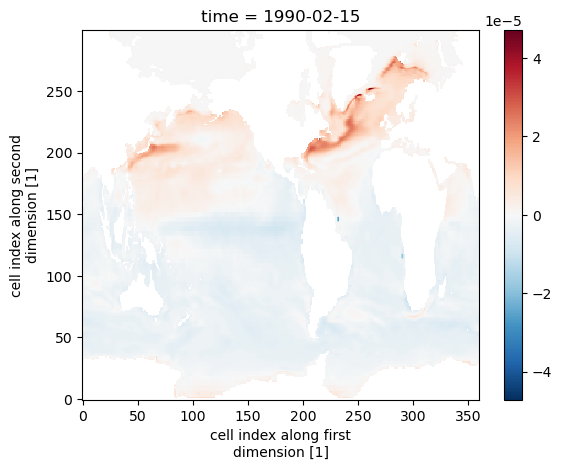

In [97]:
tem_mix[0,:,:].plot()

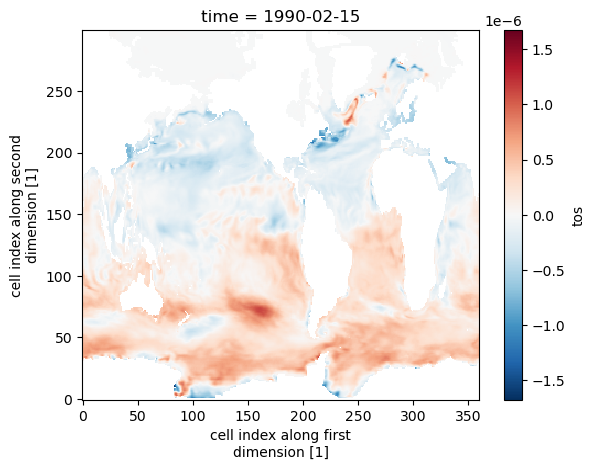

In [96]:
tem_dif[0,:,:].plot()

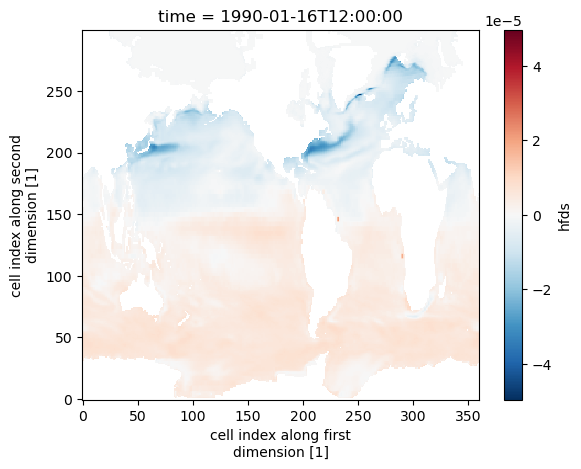

In [99]:
(hf_test[0,:,:]/(reference_density*specific_heat*mix_layer_depth)).plot()

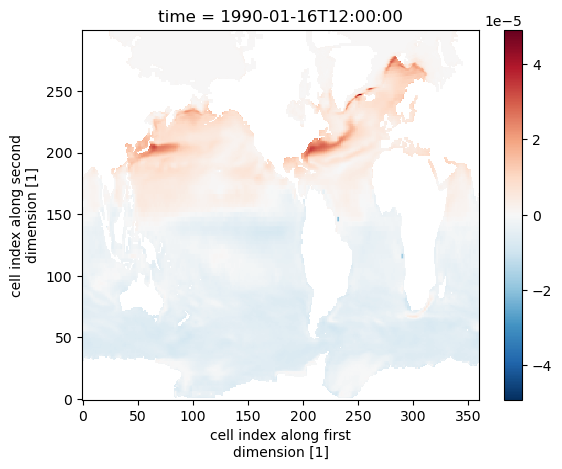

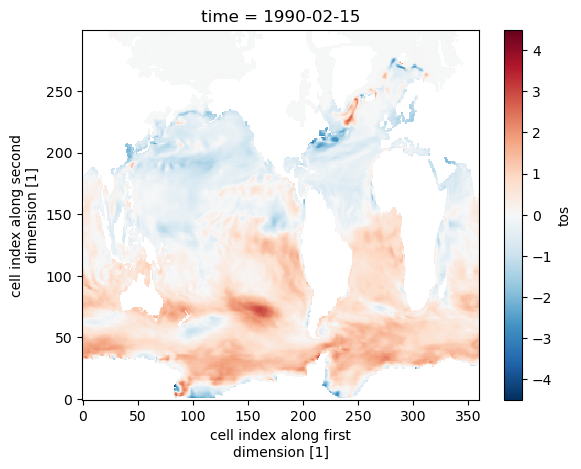

In [52]:
tem_dif[0,:,:].plot()

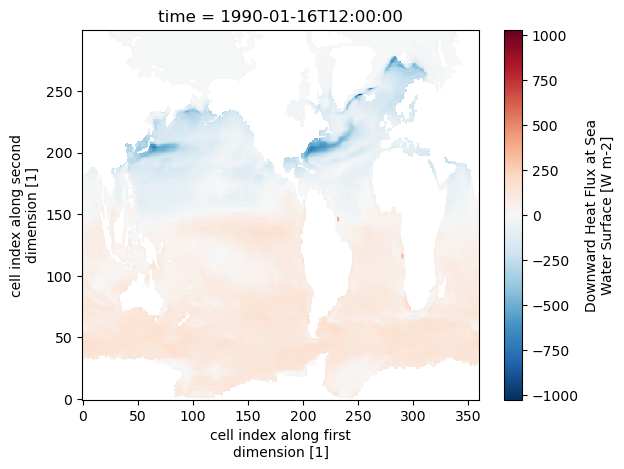

In [78]:
hf_test[0,:,:].plot()

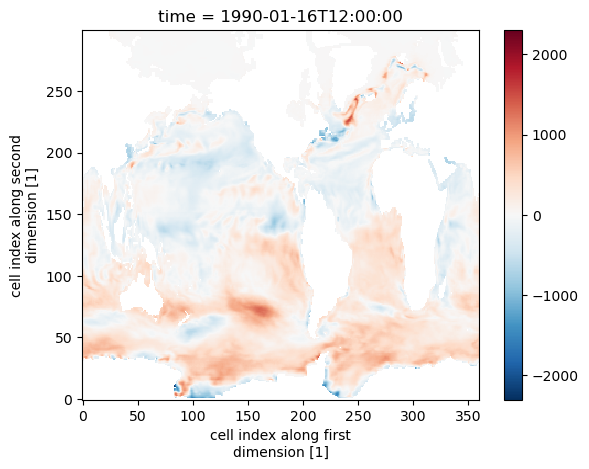

In [79]:
(tem_mix[0,:,:]*(reference_density*specific_heat*mix_layer_depth)).plot()

In [61]:
sp_season = gsw.spiciness0(sal_mean,tem_mean)
all_12 = []
fwf_12 = []
hf_12 = []
tran_12 = []
mix_12 = []
sith_12 = []
# density_mean_year = density_mean
for season in season_name:     
    tr_heat_weighted_mon = tr_heat_weighted.sel(season = season)
    tr_fwf_weighted_mon = tr_fwf_weighted.sel(season = season)
    tr_sith_weighted_mon = tr_sith_weighted.sel(season = season)
    tr_mon = tr.sel(season = season)

    
    # Data sortation by density range 
    tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
    tr_list_mix = [] ; tr_list_sic = []; tr_list_sid=[]; tr_list_fwf_si=[]; tr_list_hf_si=[]
    tr_list_sith = []
    x_lim = [24.5, 28.5]
    interval = 0.1  # Set the interval for the water mass transformation
    sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
    km2 = 10**6 # Unit for km2
    sea_ice_threshold = 1.25  # The sea ice concentration threshold for freshwater flux integration

    density_range =  np.arange(x_lim[0], x_lim[1], interval) 
    density_applied = density_mean.sel(season = season).where(density_mean.sel(season = season)[lat_key]<lat_edge) # sift the density range

    for den in density_range:
        den_left = 1000 + den - interval/2; den_right = 1000 + den + interval/2 # the right and left density boundary 

        #====Here the density difference is setted as half interval 
        den_dif = interval
        tr_hf = tr_heat_weighted_mon.where(density_applied > den_left).where(density_applied < den_right) / den_dif  / sverdrop      
        tr_fwf = tr_fwf_weighted_mon.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
        tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
        tr_sith = tr_sith_weighted_mon.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
        # tr_hf = tr_heat_weighted_mon.where(density_applied < den_right) / den_dif  / sverdrop      
        # tr_fwf = tr_fwf_weighted_mon.where(density_applied < den_right)  / den_dif / sverdrop
        # tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
        # tr_sith = tr_sith_weighted_mon.where(density_applied < den_right)  / den_dif / sverdrop
        
        # Ocean realm
        hf_all = tr_hf.sum().values.item()
        fwf_all = tr_fwf.sum().values.item()
        tran_all = -tr_tran.sum().values.item()
        
        # sea ice realm
        sith_all = tr_sith.sum().values.item()

        tr_list_all.append(hf_all+fwf_all)
        tr_list_hf.append(hf_all)
        tr_list_fwf.append(fwf_all)
        tr_list_tran.append(tran_all)
        tr_list_mix.append(tran_all - hf_all - fwf_all)
        tr_list_sith.append(sith_all)
        
    all_12.append(tr_list_all)
    fwf_12.append(tr_list_fwf)
    sith_12.append(tr_list_sith)
    hf_12.append(tr_list_hf)
    tran_12.append(tr_list_tran)
    mix_12.append(tr_list_mix)

all_data = np.array(all_12).mean(axis = 0)
fwf_data = np.array(fwf_12).mean(axis = 0)
hf_data = np.array(hf_12).mean(axis = 0)
tran_data = np.array(tran_12).mean(axis = 0)
mix_data = np.array(mix_12).mean(axis = 0)
sith_data = np.array(sith_12).mean(axis = 0)

In [69]:
sp_season = gsw.spiciness0(sal_mean,tem_mean)
all_12 = []
fwf_12 = []
hf_12 = []
tran_12 = []
mix_12 = []
sith_12 = []
   
tr_heat_weighted_mon = tr_heat_weighted.mean('season')
tr_fwf_weighted_mon = tr_fwf_weighted.mean('season')
tr_sith_weighted_mon = tr_sith_weighted.mean('season')
tr_mon = tr.mean('season')


# Data sortation by density range 
tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
tr_list_mix = [] ; tr_list_sic = []; tr_list_sid=[]; tr_list_fwf_si=[]; tr_list_hf_si=[]
tr_list_sith = []
x_lim = [24.5, 28.5]
interval = 0.1  # Set the interval for the water mass transformation
sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
km2 = 10**6 # Unit for km2
sea_ice_threshold = 1.25  # The sea ice concentration threshold for freshwater flux integration

density_range =  np.arange(x_lim[0], x_lim[1], interval) 
density_applied = density_mean.mean('season').where(density_mean.mean('season')[lat_key]<lat_edge) # sift the density range

for den in density_range:
    den_left = 1000 + den - interval/2; den_right = 1000 + den + interval/2 # the right and left density boundary 

    #====Here the density difference is setted as half interval 
    den_dif = interval
    tr_hf = tr_heat_weighted_mon.where(density_applied > den_left).where(density_applied < den_right) / den_dif  / sverdrop      
    tr_fwf = tr_fwf_weighted_mon.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
    tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
    tr_sith = tr_sith_weighted_mon.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
    # tr_hf = tr_heat_weighted_mon.where(density_applied < den_right) / den_dif  / sverdrop      
    # tr_fwf = tr_fwf_weighted_mon.where(density_applied < den_right)  / den_dif / sverdrop
    # tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
    # tr_sith = tr_sith_weighted_mon.where(density_applied < den_right)  / den_dif / sverdrop
    
    # Ocean realm
    hf_all = tr_hf.sum().values.item()
    fwf_all = tr_fwf.sum().values.item()
    tran_all = -tr_tran.sum().values.item()
    
    # sea ice realm
    sith_all = tr_sith.sum().values.item()

    tr_list_all.append(hf_all+fwf_all)
    tr_list_hf.append(hf_all)
    tr_list_fwf.append(fwf_all)
    tr_list_tran.append(tran_all)
    tr_list_mix.append(tran_all - hf_all - fwf_all)
    tr_list_sith.append(sith_all)
    
# all_12.append(tr_list_all)
# fwf_12.append(tr_list_fwf)
# sith_12.append(tr_list_sith)
# hf_12.append(tr_list_hf)
# tran_12.append(tr_list_tran)
# mix_12.append(tr_list_mix)

all_data = np.array(tr_list_all)
fwf_data = np.array(tr_list_fwf)
hf_data = np.array(tr_list_hf)
tran_data = np.array(tr_list_tran)
mix_data = np.array(tr_list_mix)
sith_data = np.array(tr_list_sith)

(24.5, 28.5)

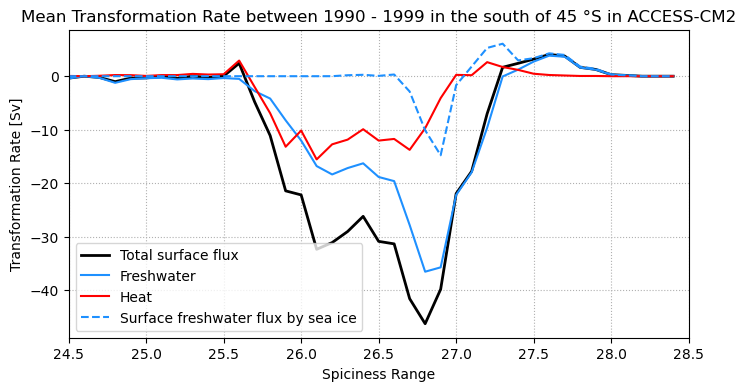

In [70]:

fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax = axs
ax.plot(density_range, all_data , label='Total surface flux',linewidth=2, color = 'black')
ax.plot(density_range, fwf_data , label='Freshwater',color = 'dodgerblue')
ax.plot(density_range, hf_data, label='Heat',color = 'r')
ax.plot(density_range, sith_data, label='Surface freshwater flux by sea ice',linestyle = '--',color = 'dodgerblue')

# ax.plot(density_range, tran_data, label='M$_{45°S}$(Water volumn transportation)',color = 'y')
# ax.plot(density_range, fwf_data - sith_data, label='E-P',color = 'y')

# ax.plot(density_range, mix_data, label='G$_{mix}$(Residule)',color = 'g')

# Add a legend
ax.legend()

# Add a grid
ax.grid(linestyle = ':')

# Set the x and y axis labels
ax.set_xlabel('Spiciness Range')
ax.set_ylabel('Transformation Rate [Sv]')
ax.set_title(fig_title)
ax.set_xlim(x_lim)
# ax.set_ylim(-40,20)

(24.5, 28.5)

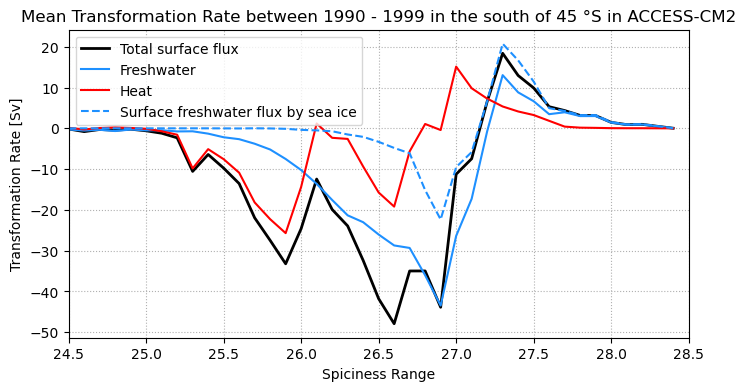

In [63]:

fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax = axs
ax.plot(density_range, all_data , label='Total surface flux',linewidth=2, color = 'black')
ax.plot(density_range, fwf_data , label='Freshwater',color = 'dodgerblue')
ax.plot(density_range, hf_data, label='Heat',color = 'r')
ax.plot(density_range, sith_data, label='Surface freshwater flux by sea ice',linestyle = '--',color = 'dodgerblue')

# ax.plot(density_range, tran_data, label='M$_{45°S}$(Water volumn transportation)',color = 'y')
# ax.plot(density_range, fwf_data - sith_data, label='E-P',color = 'y')

# ax.plot(density_range, mix_data, label='G$_{mix}$(Residule)',color = 'g')

# Add a legend
ax.legend()

# Add a grid
ax.grid(linestyle = ':')

# Set the x and y axis labels
ax.set_xlabel('Spiciness Range')
ax.set_ylabel('Transformation Rate [Sv]')
ax.set_title(fig_title)
ax.set_xlim(x_lim)
# ax.set_ylim(-40,20)

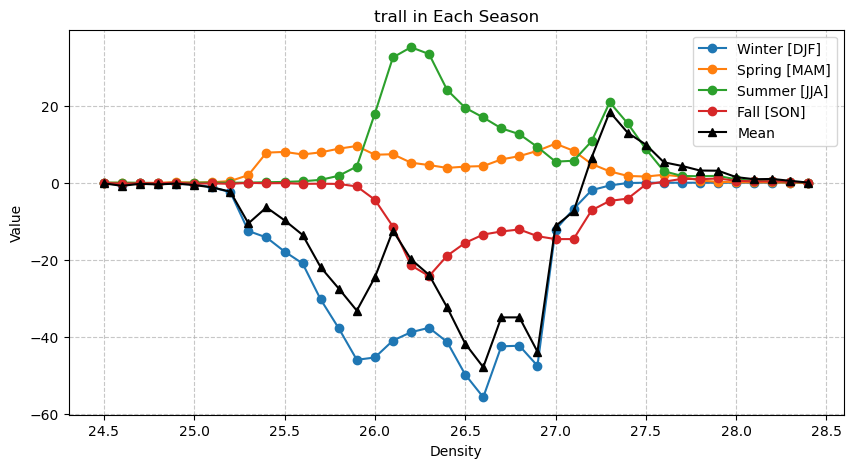

In [91]:
# Show the plot
data_plot = all_season

season_label = ['Winter [DJF]', 'Spring [MAM]', 'Summer [JJA]', 'Fall [SON]']
mean_data_plot = data_plot.mean('season')
plt.figure(figsize=(10, 5))
(data_plot/4).plot.line(x='density', hue='season', marker='o',label = season_label)
mean_data_plot.plot.line(x='density', hue='season', marker='^',color = 'k' ,label = 'Mean')
plt.xlabel('Density')
plt.ylabel('Value')
plt.title(f'{data_plot.name} in Each Season')
plt.legend()
plt.grid(linestyle = '--',alpha =0.7)
plt.show()

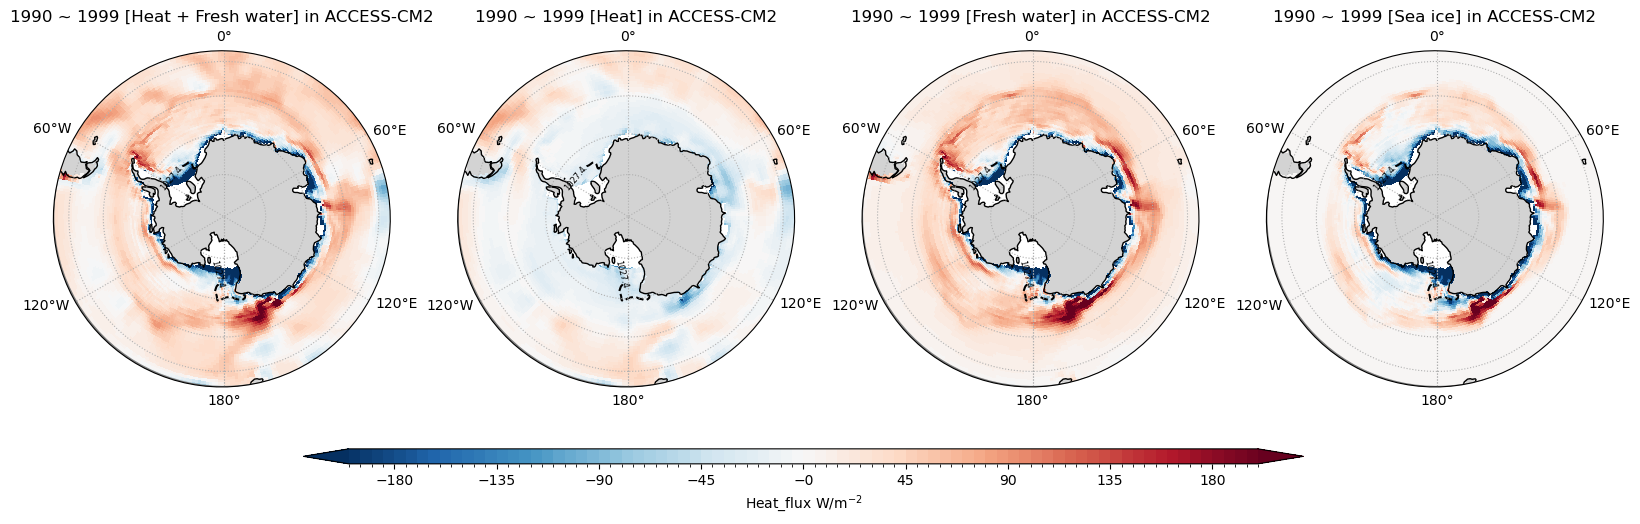

In [12]:
pre_mean_climate = 0   

hf_mean_climate = hf_mean.mean('season')
fwf_mean_climate = fwf_mean.mean('season')
sal_mean_climate = sal_mean.mean('season')
tem_mean_climate = tem_mean.mean('season')
sith_mean_climate = sith_mean.mean('season')
den_sorted_climate =den_sorted.mean('season')
######## 3.5 Transformation rate plot ######
buo, buo_hf, buo_fwf = wmt.buoyancy_flux(hf_mean_climate, fwf_mean_climate, sal_mean_climate, tem_mean_climate, pre_mean_climate,
                                         formula='hf_term') # 'default'
buo_si = wmt.buoyancy_flux_water_to_heat(sith_mean_climate,sal_mean_climate, tem_mean_climate, pre_mean_climate)

lat_edge = -45

###==== Removal of redundant values ===##

if 'NorESM2' in model:
    # Select the unique values 
    buo = buo[:-1,:]
    buo_hf = buo_hf[:-1,:]
    buo_fwf  = buo_fwf[:-1,:]
    density_mean = density_mean[:-1,:]
    grid_area = grid_area[:-1,:]
###=====================================##

buo_year = buo.where(buo[lat_key]<lat_edge)
buo_hf_year = buo_hf.where(buo[lat_key]<lat_edge)
buo_fwf_year = buo_fwf.where(buo[lat_key]<lat_edge)
buo_si_year = buo_si.where(buo[lat_key]<lat_edge)


sign_changes = np.where(np.diff(np.sign(tr_list_all)))[0]
flip_point_den_pre = density_range[sign_changes[-1]]
intercept = interval* (abs(tr_list_all[sign_changes[-1]+1])/(abs(tr_list_all[sign_changes[-1]]) + abs(tr_list_all[sign_changes[-1]+1])))
# [abs(tr_list_all[sign_changes[-1]+1]), (abs(tr_list_all[sign_changes[-1]]) + abs(tr_list_all[sign_changes[-1]+1]))]

flip_point_den = [flip_point_den_pre + intercept + 1000]
flip_point_den

value_list = tr_list_sith

sign_changes = np.where(np.diff(np.sign(value_list)))[0]
sign_changes

max_index = value_list.index(max(value_list))
min_index = value_list.index(min(value_list))
fwf_0point_index = [index for index in sign_changes if (min_index <= index <= max_index) or (min_index >= index >= max_index)] # find the point between max and min
intercept = interval * (abs(value_list[fwf_0point_index[0]])/(abs(value_list[fwf_0point_index[0]]) + abs(value_list[fwf_0point_index[0]+1])))
fwf_si_flip_den = [density_range[fwf_0point_index[0]] + intercept + 1000]
fwf_si_flip_den

data_list = [buo_year, buo_hf_year, buo_fwf_year, buo_si_year]
title_list = [' [Heat + Fresh water]' , ' [Heat]', ' [Fresh water]', ' [Sea ice]']

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10),
                        subplot_kw=dict(projection=ccrs.Orthographic(0, -90)) #,facecolor="gray"
                       )

for index, data in enumerate(data_list):

    fig1 = data.plot(x = lon_key,y = lat_key,
                    transform=ccrs.PlateCarree(),
                    levels = np.arange(-200.1, 200.1, 5), 
                    add_colorbar=False,
                    ax = axs[index],
                    # cmap = cmap_br
                    )

    #== Plot the density contour  
    # The raw data is not flat, flaten the density data and get rid of the abnomal column
    if len(den_sorted_climate[0,:]) > 800:
        den_filtered = den_sorted_climate[:,5:-5]
    else:
        den_filtered = den_sorted_climate[:,1:-1]   
    den_contour = den_filtered.plot.contour(x=lon_key, y=lat_key, levels=fwf_si_flip_den,
                                          ax = axs[index],
                                          transform=ccrs.PlateCarree(),
                                          colors = 'k',
                                          linestyles='dashed')


    ax = axs[index]
    ax.coastlines()
    ax.gridlines(linestyle = ':',draw_labels=True)
    ax.set_extent([-180, 180, -90, lat_edge], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray') # add the land map
    ax.set_title( yrst + ' ~ ' + yren + title_list[index] + ' in ' + model)  # Set the title   
    ax.clabel(den_contour, inline=True, fontsize=6, inline_spacing=10,fmt='%.1f')  # Set the lable of the contour

    # Add solid line at 50°S latitude
    # Plot the line segment
    lon = np.linspace(-180, 180, 100)
    lat = np.full_like(lon, lat_edge)
    ax.plot(lon, lat, color='gray', linestyle='-', transform=ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

cbar = fig.colorbar(fig1, ax=axs.ravel().tolist(), 
                    cax=fig.add_axes([0.25, 0.25, 0.5, 0.015]),
                    orientation = 'horizontal',
                   )
cbar.set_label(f'{buo.standard_name} {buo.units}')

plt.show()
# if figure_plot_trigger:
#     fig.savefig(fig_path + '1buo_' + model +'.png')

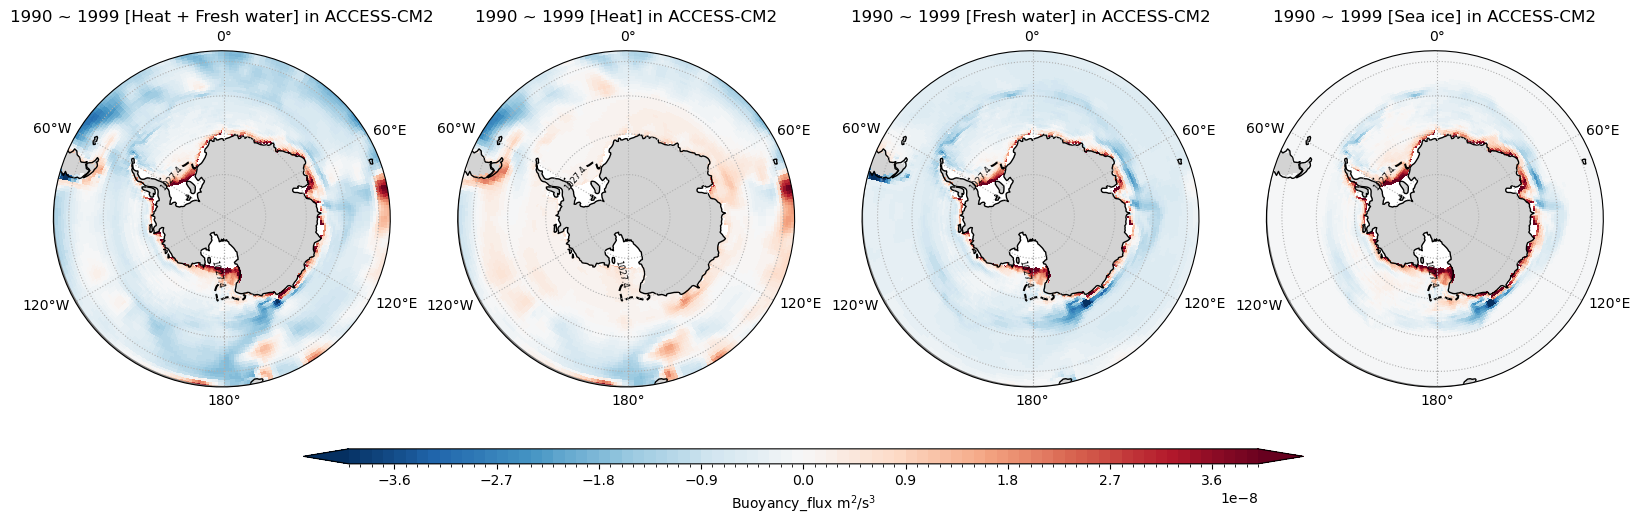

In [13]:
pre_mean_climate = 0   

hf_mean_climate = hf_mean.mean('season')
fwf_mean_climate = fwf_mean.mean('season')
sal_mean_climate = sal_mean.mean('season')
tem_mean_climate = tem_mean.mean('season')
sith_mean_climate = sith_mean.mean('season')
den_sorted_climate =den_sorted.mean('season')
######## 3.5 Transformation rate plot ######
buo, buo_hf, buo_fwf = wmt.buoyancy_flux(hf_mean_climate, fwf_mean_climate, sal_mean_climate, tem_mean_climate, pre_mean_climate,
                                         formula='default') 
buo_si = wmt.buoyancy_flux_water(sith_mean_climate,sal_mean_climate, tem_mean_climate, pre_mean_climate)

lat_edge = -45

###==== Removal of redundant values ===##

if 'NorESM2' in model:
    # Select the unique values 
    buo = buo[:-1,:]
    buo_hf = buo_hf[:-1,:]
    buo_fwf  = buo_fwf[:-1,:]
    density_mean = density_mean[:-1,:]
    grid_area = grid_area[:-1,:]
###=====================================##

buo_year = buo.where(buo[lat_key]<lat_edge)
buo_hf_year = buo_hf.where(buo[lat_key]<lat_edge)
buo_fwf_year = buo_fwf.where(buo[lat_key]<lat_edge)
buo_si_year = buo_si.where(buo[lat_key]<lat_edge)


sign_changes = np.where(np.diff(np.sign(tr_list_all)))[0]
flip_point_den_pre = density_range[sign_changes[-1]]
intercept = interval* (abs(tr_list_all[sign_changes[-1]+1])/(abs(tr_list_all[sign_changes[-1]]) + abs(tr_list_all[sign_changes[-1]+1])))
# [abs(tr_list_all[sign_changes[-1]+1]), (abs(tr_list_all[sign_changes[-1]]) + abs(tr_list_all[sign_changes[-1]+1]))]

flip_point_den = [flip_point_den_pre + intercept + 1000]
flip_point_den

value_list = tr_list_sith

sign_changes = np.where(np.diff(np.sign(value_list)))[0]
sign_changes

max_index = value_list.index(max(value_list))
min_index = value_list.index(min(value_list))
fwf_0point_index = [index for index in sign_changes if (min_index <= index <= max_index) or (min_index >= index >= max_index)] # find the point between max and min
intercept = interval * (abs(value_list[fwf_0point_index[0]])/(abs(value_list[fwf_0point_index[0]]) + abs(value_list[fwf_0point_index[0]+1])))
fwf_si_flip_den = [density_range[fwf_0point_index[0]] + intercept + 1000]
fwf_si_flip_den

data_list = [buo_year, buo_hf_year, buo_fwf_year, buo_si_year]
title_list = [' [Heat + Fresh water]' , ' [Heat]', ' [Fresh water]', ' [Sea ice]']

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10),
                        subplot_kw=dict(projection=ccrs.Orthographic(0, -90)) #,facecolor="gray"
                       )

for index, data in enumerate(data_list):

    fig1 = data.plot(x = lon_key,y = lat_key,
                    transform=ccrs.PlateCarree(),
                    levels = np.arange(-4e-8, 4.01e-8, 1e-9), 
                    add_colorbar=False,
                    ax = axs[index]
                    )

    #== Plot the density contour  
    # The raw data is not flat, flaten the density data and get rid of the abnomal column
    if len(den_sorted_climate[0,:]) > 800:
        den_filtered = den_sorted_climate[:,5:-5]
    else:
        den_filtered = den_sorted_climate[:,1:-1]   
    den_contour = den_filtered.plot.contour(x=lon_key, y=lat_key, levels=fwf_si_flip_den,
                                          ax = axs[index],
                                          transform=ccrs.PlateCarree(),
                                          colors = 'k',
                                          linestyles='dashed')


    ax = axs[index]
    ax.coastlines()
    ax.gridlines(linestyle = ':',draw_labels=True)
    ax.set_extent([-180, 180, -90, lat_edge], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray') # add the land map
    ax.set_title( yrst + ' ~ ' + yren + title_list[index] + ' in ' + model)  # Set the title   
    ax.clabel(den_contour, inline=True, fontsize=6, inline_spacing=10,fmt='%.1f')  # Set the lable of the contour

    # Add solid line at 50°S latitude
    # Plot the line segment
    lon = np.linspace(-180, 180, 100)
    lat = np.full_like(lon, lat_edge)
    ax.plot(lon, lat, color='gray', linestyle='-', transform=ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

cbar = fig.colorbar(fig1, ax=axs.ravel().tolist(), 
                    cax=fig.add_axes([0.25, 0.25, 0.5, 0.015]),
                    orientation = 'horizontal',
                   )
cbar.set_label(buo.standard_name + ' ' + buo.units)

plt.show()
# if figure_plot_trigger:
#     fig.savefig(fig_path + '1buo_' + model +'.png')

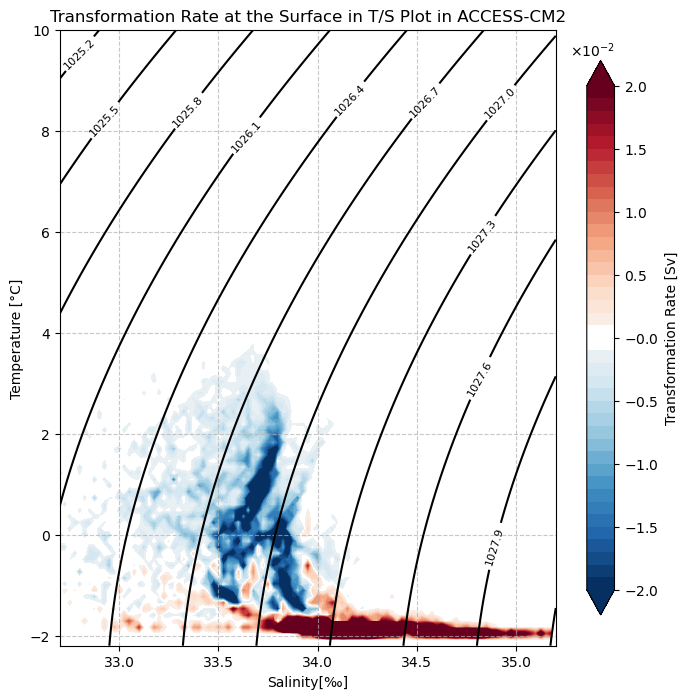

In [14]:
# Define the latitude limit, salinity limit, and temperature limit
lat_edge_1 = -45
sal_lim = [32.7, 35.2]
tem_lim = [-2.2, 10]

# tr_hf_weighted
# tr_sur = (tr_fwf_weighted-tr_sith_weighted) /sverdrop
# tr_sur = tr_fwf_weighted /sverdrop
tr_sur = tr_sith_weighted/sverdrop

# Filter the data based on latitude limit
sal_p = sal_mean.where(sal_mean[lat_key] < lat_edge_1)
tem_p = tem_mean.where(sal_mean[lat_key] < lat_edge_1)
tr_sur_p = tr_sur.where(sal_mean[lat_key] < lat_edge_1)

# Calculate density using gsw library
pressure = 0  # Assuming surface pressure for simplicity
den_p = gsw.rho(sal_p, tem_p, pressure)

# Create a new grid to accumulate "tr_sur" values
# Define the number of bins for salinity and temperature
num_bins_sal = 100
num_bins_tem = 100

plt.figure(figsize=(8, 8))
# Calculate the 2D histogram-like bins
hist2D, tem_edges , sal_edges= np.histogram2d(tem_p.values.flatten(),
                                              sal_p.values.flatten(),
                                              bins=[num_bins_sal, num_bins_tem],
                                              range=[tem_lim,sal_lim],
                                              weights=tr_sur_p.values.flatten())

# Normalize the accumulated values by the number of occurrences in each bin to get the mean "tr_sur"
# hist2D[hist2D == 0] = np.nan  # Set zero values to NaN to avoid division by zero

# Create a density contour plot
contour_plot = plt.contourf(sal_edges[:-1], tem_edges[:-1], 
                            # tr_sur_accumulated,
                            hist2D/4,
                            cmap = cmap_br,#'RdBu_r',  # You can change the colormap as needed  # cm.balance, #
                            levels=  np.arange(-0.02001, 0.02001, 0.001), # np.linspace(-0.02, 0.02, 20), #
                            # levels=np.arange(-0.006, 0.006, 0.001)
                            extend='both'
                           )

# Define the temperature and salinity ranges
sal_range = np.linspace(sal_lim[0], sal_lim[1], 100)
tem_range = np.linspace(tem_lim[0], tem_lim[1], 100)

# Create a grid of temperature and salinity values
temperature, salinity = np.meshgrid(tem_range, sal_range)

# Calculate density using gsw library
density = gsw.rho(salinity, temperature, pressure)

# Create a density contour plot
contour_lines = plt.contour(salinity, temperature, density, colors='k', levels=10)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')  # Add labels to contour lines



# Format color bar tick labels in scientific notation
cbar = plt.colorbar(contour_plot,shrink=0.9)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))  # Set the power limits to show scientific notation from -3 to 3
cbar.formatter = formatter
cbar.update_ticks()
cbar.set_label('Transformation Rate [Sv]')
# cbar.
# cbar.ax.yaxis.set_offset_position('right')
# cbar.ax.yaxis.get_offset_text().set_x(3.5) 


# Labels and title
plt.xlabel('Salinity[‰]')
plt.ylabel('Temperature [°C]')
plt.title(f'Transformation Rate at the Surface in T/S Plot in {model}')

# Set the plot limits
plt.xlim(sal_lim)
plt.ylim(tem_lim)

plt.grid(linestyle = '--', alpha = 0.7)
plt.show()

In [15]:
stop

NameError: name 'stop' is not defined

In [ ]:
##==== Save the transformation data====##
if data_save_trigger:
    # Create an xarray DataArray for the density range
    density_range_da = xr.DataArray(density_range, dims='density', coords={'density': density_range})

    # Combine the 1D arrays into a Dataset
    dataset = xr.Dataset({
        'tr_list_all': ('density', tr_list_all),
        'tr_list_hf': ('density', tr_list_hf),
        'tr_list_fwf': ('density', tr_list_fwf),
        'tr_list_tran': ('density', tr_list_tran),
        'tr_list_mix': ('density', tr_list_mix),
        'tr_list_sic': ('density', tr_list_sic),
        'tr_list_sid': ('density', tr_list_sid),
        'tr_list_sith': ('density', tr_list_sith),        
        'density_range': density_range_da
    })

    # dataset = xr.Dataset(data_dict, coords={'density_range': density_range})

    # Add yrst and yren as attributes to the Dataset
    dataset.attrs['yrst'] = yrst
    dataset.attrs['yren'] = yren
    dataset.attrs['lat_edge'] = lat_edge
    dataset.attrs['model'] = model
    dataset.attrs['description'] = 'Water Mass transformation Data'

    # File path to save the data
    file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Transf_{model}_{yrst}_{yren}.nc'

    # Save the Dataset to a NetCDF file
    dataset.to_netcdf(file_path)

if data_save_trigger:
    # Create a new Dataset to store all the DataArrays
    dataset = xr.Dataset({
        'buo_year': buo_year,
        'buo_hf_year': buo_hf_year,
        'buo_fwf_year': buo_fwf_year,
        'buo_si_year': buo_si_year,
        'den_mean': density_mean,
        # 'grid_area': grid_area
    })

    # Optionally, you can also add global attributes to the Dataset if needed

    # Add yrst and yren as attributes to the Dataset
    dataset.attrs['yrst'] = yrst
    dataset.attrs['yren'] = yren
    dataset.attrs['lat_edge'] = lat_edge
    dataset.attrs['model'] = model
    dataset.attrs['description'] = 'Buoyancy Flux Data'
    dataset.attrs['author'] = 'Zijin'
    dataset.attrs['lon_key'] = lon_key
    dataset.attrs['lat_key'] = lat_key
    dataset.attrs['nearest_index'] = nearest_index
    # dataset.attrs['fwf_si_flip_den'] = fwf_si_flip_den

    # File path to save the data
    file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Buo_{model}_{yrst}_{yren}.nc'
    dataset.to_netcdf(file_path)
    
if data_save_trigger:
    # Create a new Dataset to store all the DataArrays
    dataset = xr.Dataset({
        'sic_sep_mean': sic_sep_mean,
        'sic_mean': sic_mean
    })

    # Add yrst and yren as attributes to the Dataset
    dataset.attrs['yrst'] = yrst
    dataset.attrs['yren'] = yren
    dataset.attrs['lat_edge'] = lat_edge
    dataset.attrs['model'] = model
    dataset.attrs['description'] = 'Sic Data'
    dataset.attrs['author'] = 'Zijin'
    dataset.attrs['lon_key'] = lon_key
    dataset.attrs['lat_key'] = lat_key
    dataset.attrs['yrst'] = yrst
    dataset.attrs['yren'] = yren
    dataset.attrs['model'] = model

    # File path to save the data
    file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Sic_{model}_{yrst}_{yren}.nc'
    dataset.to_netcdf(file_path)
    
if data_save_trigger:
    # Define the file name to save the data
    file_path = f'/g/data/jk72/zc0441/Subject_1/Data/TS_{model}_{yrst}_{yren}.nc'

    # Create a dataset to store the DataArrays
    data_set = xr.Dataset({
        'sal_p': sal_p,
        'tem_p': tem_p,
        'tr_sur_p': tr_sur,
        'tr_heat_weighted': tr_heat_weighted,
        'tr_fwf_weighted': tr_fwf_weighted,
        'tr_sith_weighted': tr_sith_weighted,
        # 'sal_edges': xr.DataArray(sal_edges[:-1], dims=('sal_bin',), attrs={'units': '‰'}),
        # 'tem_edges': xr.DataArray(tem_edges[:-1], dims=('tem_bin',), attrs={'units': '°C'}),
        # 'hist2D': xr.DataArray(hist2D, dims=('sal_bin', 'tem_bin')),
        # 'sal_lim': xr.DataArray(sal_lim, dims=('lim',), attrs={'units': '‰'}),
        # 'tem_lim': xr.DataArray(tem_lim, dims=('lim',), attrs={'units': '°C'})
    })

    dataset.attrs['lon_key'] = lon_key
    dataset.attrs['lat_key'] = lat_key
    # Save the dataset to a NetCDF file
    data_set.to_netcdf(file_path)

In [ ]:
            ##==== Save the transformation data====##
if data_save_trigger:
    # Create an xarray DataArray for the density range
    density_range_da = xr.DataArray(density_range, dims='density', coords={'density': density_range})

    # Combine the 1D arrays into a Dataset
    dataset = xr.Dataset({
        'tr_list_all': ('density', all_data),
        'tr_list_hf': ('density', hf_data),
        'tr_list_fwf': ('density', fwf_data),
        'tr_list_tran': ('density', tran_data),
        'tr_list_mix': ('density', mix_data),
        # 'tr_list_sic': ('density', tr_list_sic),
        # 'tr_list_sid': ('density', tr_list_sid),
        'tr_list_sith': ('density', sith_data),        
        'density_range': density_range_da
    })


    # Add yrst and yren as attributes to the Dataset
    dataset.attrs['yrst'] = yrst
    dataset.attrs['yren'] = yren
    dataset.attrs['lat_edge'] = lat_edge
    dataset.attrs['model'] = model
    dataset.attrs['description'] = 'Water Mass transformation Data'

    # File path to save the data
    file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Season_Transf_{model}_{yrst}_{yren}.nc'

    # Save the Dataset to a NetCDF file
    dataset.to_netcdf(file_path)

In [ ]:
sal_raw1 = xr.open_mfdataset(file_paths[5]+'/*.nc', combine='by_coords', parallel=True)[variable_list[5]][:,:,:,:].sel(time = slice(yrst, yren))
tem_raw1 = xr.open_mfdataset(file_paths[6]+'/*.nc', combine='by_coords', parallel=True)[variable_list[6]][:,:,:,:].sel(time = slice(yrst, yren))  #.sel(**{j_key : nearest_index, 'time' : slice(yrst, yren)}).
pre_raw1 = 0

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# # Define a custom diverging color map with white in the center
# colors = [(0, 0,.8), (1, 1, 1), (.8, 0, 0)]  # Blue, White, Red
# # colors = [(0.09317630180115785, 0.11117332947760272, 0.26151238855305475), (1, 1, 1), (0.23605636466461405, 0.03529747994604029, 0.06943744239412558)]  # Blue, White, Red

# n_bins = 40  # Number of color bins
# cmap_name = "custom_diverging_white_center"
# custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
# custom_cmap 

# Get the "balance" colormap
# cmap = plt.get_cmap('RdBu_r')

# # Define the number of colors to extract
# num_colors = 40

# # Extract 40 evenly spaced colors from the colormap
# extracted_colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
# # Replace the 20th and 21st colors with white
# extracted_colors[int(num_colors/2 -1)] = (1.0, 1.0, 1.0, 1.0)  # White color
# extracted_colors[int(num_colors/2)] = (1.0, 1.0, 1.0, 1.0)  # White color

# custom_cmap = ListedColormap(extracted_colors)
# # Display the extracted colors
# fig, ax = plt.subplots(figsize=(8, 2))
# ax.imshow([extracted_colors], aspect="auto")
# ax.axis("off")

# plt.title("Extracted Colors from cm.balance")
# plt.show()

In [ ]:
# all_12 = []
# fwf_12 = []
# hf_12 = []
# tran_12 = []
# mix_12 = []
# sith_12 = []
    
# for mon_num in range(1,13):     
#     tr_heat_weighted_mon = tr_heat_weighted.sel(month = mon_num)
#     tr_fwf_weighted_mon = tr_fwf_weighted.sel(month = mon_num)
#     tr_sith_weighted_mon = tr_sith_weighted.sel(month = mon_num)
#     tr_mon = tr.sel(month = mon_num)

    
#     # Data sortation by density range 
#     tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
#     tr_list_mix = [] ; tr_list_sic = []; tr_list_sid=[]; tr_list_fwf_si=[]; tr_list_hf_si=[]
#     tr_list_sith = []
#     x_lim = [-3,10]
#     interval = 0.2  # Set the interval for the water mass transformation
#     sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
#     km2 = 10**6 # Unit for km2
#     sea_ice_threshold = 1.25  # The sea ice concentration threshold for freshwater flux integration

#     density_range =  np.arange(x_lim[0], x_lim[1], interval) 
#     density_applied = tem_mean.sel(month = mon_num).where(tem_mean[lat_key]<lat_edge) # sift the density range

#     for den in density_range:
#         den_left = den - interval/2; den_right = den + interval/2 # the right and left density boundary 

#         #====Here the density difference is setted as half interval 
#         den_dif = interval
#         # tr_hf = tr_heat_weighted_mon.where(density_applied > den_left).where(density_applied < den_right) / sverdrop      
#         # tr_fwf = tr_fwf_weighted_mon.where(density_applied > den_left).where(density_applied < den_right) / sverdrop
#         # tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
#         # tr_sith = tr_sith_weighted_mon.where(density_applied > den_left).where(density_applied < den_right) / sverdrop
#         tr_hf = tr_heat_weighted_mon.where(density_applied < den_right) / sverdrop      
#         tr_fwf = tr_fwf_weighted_mon.where(density_applied < den_right) / sverdrop
#         tr_tran = tr_mon.where(den_ver<den_right) / sverdrop
#         tr_sith = tr_sith_weighted_mon.where(density_applied < den_right) / sverdrop
        
#         # Ocean realm
#         hf_all = tr_hf.sum().values.item()
#         fwf_all = tr_fwf.sum().values.item()
#         tran_all = -tr_tran.sum().values.item()
#                     # sea ice realm
#         sith_all = tr_sith.sum().values.item()

#         tr_list_all.append(hf_all+fwf_all)
#         tr_list_hf.append(hf_all)
#         tr_list_fwf.append(fwf_all)
#         tr_list_tran.append(tran_all)
#         tr_list_mix.append(tran_all - hf_all - fwf_all)
#         tr_list_sith.append(sith_all)
        
#     all_12.append(tr_list_all)
#     fwf_12.append(tr_list_fwf)
#     sith_12.append(tr_list_sith)
#     hf_12.append(tr_list_hf)
#     tran_12.append(tr_list_tran)
#     mix_12.append(tr_list_mix)

# all_data = np.array(all_12).mean(axis = 0)
# fwf_data = np.array(fwf_12).mean(axis = 0)
# hf_data = np.array(hf_12).mean(axis = 0)
# tran_data = np.array(tran_12).mean(axis = 0)
# mix_data = np.array(mix_12).mean(axis = 0)
# sith_data = np.array(sith_12).mean(axis = 0)
# # all_data.mean(axis = 1)

# fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'

# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# ax = axs
# ax.plot(density_range, all_data, label='Total surface flux',linewidth=2, color = 'black')
# ax.plot(density_range, fwf_data, label='Freshwater',color = 'dodgerblue')
# ax.plot(density_range, hf_data, label='Heat',color = 'r')
# ax.plot(density_range, sith_data, label='Surface freshwater flux by sea ice',linestyle = '--',color = 'dodgerblue')

# # ax.plot(density_range, tran_data, label='M$_{45°S}$(Water volumn transportation)',color = 'y')
# # ax.plot(density_range, fwf_data - sith_data, label='E-P',color = 'y')

# # ax.plot(density_range, mix_data, label='G$_{mix}$(Residule)',color = 'g')

# # Add a legend
# ax.legend()

# # Add a grid
# ax.grid(linestyle = ':')

# # Set the x and y axis labels
# ax.set_xlabel('Temperature Range')
# ax.set_ylabel('Transformation Rate [Sv]')
# ax.set_title(fig_title)
# ax.set_xlim(x_lim)
# # ax.set_ylim(-40,20)

In [ ]:
    
    # all_12 = []
    # fwf_12 = []
    # hf_12 = []
    # tran_12 = []
    # mix_12 = []
    # sith_12 = []
    # for mon_num in range(1,13):   
    #     # tem_mon = tem.sel(time = tem['time.month']==mon_num)
    #     # sal_mon = sal.sel(time = sal['time.month']==mon_num)
    #     # hf_mon = hf.sel(time = hf['time.month']==mon_num)
    #     # fwf_mon = fwf.sel(time = fwf['time.month']==mon_num)
    #     # mty_mon = mty.sel(time = mty['time.month']==mon_num)
    #     # pre_mon = pre.sel(time = pre['time.month']==mon_num)
    #     # sith_mon = sith.sel(time = sith['time.month']==mon_num)
    #     # sic_mon = sic.sel(time = sic['time.month']==mon_num)
    
    #     sal_ver = sal_raw.sel(time = sal_raw['time.month']==mon_num).mean('time')
    #     tem_ver = tem_raw.sel(time = tem_raw['time.month']==mon_num).mean('time')
    #     pre_ver = xr.zeros_like(tem_ver)

    
    #     # calculate the total transportation within the boundary
    #     mt = mty[:,:,nearest_index,:].mean('time').compute()
    #     den_ver = gsw.rho(sal_ver,tem_ver,pre_ver)
    #     tr = mt/den_ver
    
    
    
    #     # Variable mean
    #     hf_mean = hf_mon.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    #     fwf_mean = fwf_mon.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    #     sal_mean = sal_mon.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    #     tem_mean = tem_mon.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    #     sic_mean = sic_mon.where(sic[lat_key]<lat_edge).mean('time').compute()
    #     sith_mean = sith_mon.where(sith[lat_key]<lat_edge).mean('time').compute()
        
    #     sic_sep_mean = sic.sel(time=sic['time.month'] == 9).mean(dim='time')
    #     sic_sep_mean = sic_sep_mean.where(sic_sep_mean[lat_key]<lat_edge) ## The max sea ice extent
        
    #     ##====Only for the FGOALS models, where the sea ice grid is reversied ====##
    #     if 'FGOALS' in model:
    #         sith_mean_m = sith_mean.loc[dict(j=slice(None, None, -1))]
    #         sith_mean = xr.DataArray(sith_mean_m, coords=fwf_mean.coords, dims=fwf_mean.dims)
        
    #     pre_mean = 0
    #     density_mean = gsw.rho(sal_mean, tem_mean, pre_mean)
    
    #     tr_heat_weighted = wmt.trans_rate_heat(hf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    #     tr_fwf_weighted = wmt.trans_rate_water(fwf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    #     tr_sith_weighted = wmt.trans_rate_water(sith_mean, sal_mean, tem_mean, pre_mean) * grid_area
    #     sic_weighted = sic_mean * grid_area
    
    #     ### Flag session only for FGOALS models
    #     if 'FGOALS' in model:
    #         result_values = mt.values / den_ver.values
    #         # Create a new DataArray from the result_values array
    #         tr = xr.DataArray(result_values, coords=den_ver.coords, dims=den_ver.dims)
    
    #     my_array = mt[lon_key].values
    #     unique_values, unique_indices = np.unique(my_array, return_index=True)
    #     # Check if the array contains duplicates
    #     has_duplicates = len(unique_values) < len(my_array)
        
    #     # if 'EC-Earth' or 'CNRM' or 'IPSL' in model:
    #     if 'EC-Earth' in model or 'CNRM-CM6-1-HR' in model: 
    #         if has_duplicates:
    #             # Select the unique values 
    #             tr_heat_weighted = tr_heat_weighted[:,unique_indices]
    #             tr_fwf_weighted = tr_fwf_weighted[:,unique_indices]
    #             tr_sith_weighted = tr_sith_weighted[:,unique_indices]
    #             tr = tr[:,unique_indices]
    #             sic_mean = sic_mean[:,unique_indices]
    #             sic_sep_mean = sic_sep_mean[:,unique_indices]
    #             density_mean = density_mean[:,unique_indices]
    #             den_ver = den_ver[:,unique_indices]
    #             sal_ver = sal_ver[:,unique_indices]
    #             tem_ver = tem_ver[:,unique_indices]
    #             sal_mean = sal_mean[:,unique_indices]
    #             tem_mean = tem_mean[:,unique_indices]
    #             sith_mean = sith_mean[:,unique_indices]
    #             sic_weighted =sic_weighted[:,unique_indices]
    #             hf_mean = hf_mean[:,unique_indices]
    #             fwf_mean = fwf_mean[:,unique_indices]
    
    #     den_sorted = density_mean.sortby(density_mean[lon_key][nearest_index,:])
    
    #     # Data sortation by density range 
    #     tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
    #     tr_list_mix = [] ; tr_list_sic = []; tr_list_sid=[]; tr_list_fwf_si=[]; tr_list_hf_si=[]
    #     tr_list_sith = []
    #     x_lim = [24.5,28.5]
    #     interval = 0.1  # Set the interval for the water mass transformation
    #     sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
    #     km2 = 10**6 # Unit for km2
    #     sea_ice_threshold = 1.25  # The sea ice concentration threshold for freshwater flux integration
    
    #     density_range =  np.arange(x_lim[0], x_lim[1], interval) 
    #     density_applied = density_mean.where(density_mean[lat_key]<lat_edge) # sift the density range
    
    #     for den in density_range:
    #         den_left = 1000 + den - interval/2; den_right = 1000 + den + interval/2 # the right and left density boundary 

    #         #====Here the density difference is setted as half interval 
    #         den_dif = interval
    #         tr_hf = tr_heat_weighted.where(density_applied > den_left).where(density_applied < den_right) / den_dif  / sverdrop
    #         tr_hf_si = tr_heat_weighted.where(density_applied > den_left).where(density_applied < den_right).where(sic_mean>sea_ice_threshold) / den_dif  / sverdrop
    #         tr_fwf = tr_fwf_weighted.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
    #         tr_fwf_si = tr_fwf_weighted.where(density_applied > den_left).where(density_applied < den_right).where(sic_mean>sea_ice_threshold)  / den_dif / sverdrop
    #         tr_tran = tr.where(den_ver<den_right) / sverdrop
    #         # tr_sic = sic_weighted.where(density_applied > den_left).where(density_applied < den_right) ## sic area integration
    #         tr_sic = sic_weighted.where(density_applied < den_right) / km2 ## sic area integration
    #         tr_si_distribute = sic_weighted.where(density_applied > den_left).where(density_applied < den_right) # sea ice distribution
    #         tr_sith = tr_sith_weighted.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
    #         # Ocean realm
    #         hf_all = tr_hf.sum().values.item()
    #         fwf_all = tr_fwf.sum().values.item()
    #         tran_all = -tr_tran.sum().values.item()
    #         hf_si_all = tr_hf_si.sum().values.item()
    #         fwf_si_all = tr_fwf_si.sum().values.item()
    #         # sea ice realm
    #         sic_range_mean = tr_sic.sum().values.item()
    #         sic_distribution_mean = tr_si_distribute.sum().values.item()
    #         sith_all = tr_sith.sum().values.item()
    
    #         tr_list_all.append(hf_all+fwf_all)
    #         tr_list_hf.append(hf_all)
    #         tr_list_fwf.append(fwf_all)
    #         tr_list_tran.append(tran_all)
    #         tr_list_mix.append(tran_all - hf_all - fwf_all)
    #         tr_list_sic.append(sic_range_mean)
    #         tr_list_sid.append(sic_distribution_mean)
    #         tr_list_hf_si.append(hf_si_all)
    #         tr_list_fwf_si.append(fwf_si_all)
    #         tr_list_sith.append(sith_all)
            
    #     all_12.append(tr_list_all)
    #     fwf_12.append(tr_list_fwf)
    #     sith_12.append(tr_list_sith)
    #     hf_12.append(tr_list_hf)
    #     tran_12.append(tr_list_tran)
    #     mix_12.append(tr_list_mix)
    #     # Plot of the tansformation rate 
    #     # fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'
    #     fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model} in {calendar.month_name[mon_num]}'

    #     fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
    
    #     ax = axs
    #     ax.plot(density_range, tr_list_all, label='Total(heat + freshwater)',linewidth=2, color = 'black')
    #     ax.plot(density_range, tr_list_fwf, label='Surface freshwater flux',color = 'dodgerblue')
    #     ax.plot(density_range, tr_list_hf, label='Surface heat flux',color = 'r')
    #     # ax.plot(density_range, tr_list_tran, label='M$_{45°S}$(Water volume transportation)',color = 'y')
    #     # ax.plot(density_range, tr_list_mix, label='Intra-oceanic mixing',color = 'g')
    #     # ax.plot(density_range, tr_list_fwf_si, label='Surface fwf where covered by sea ice',linestyle = '--',color = 'b')
    #     ax.plot(density_range, tr_list_sith, label='Surface freshwater flux by sea ice',linestyle = '--',color = 'dodgerblue')
    #     # ax.plot(density_range,pd.array(tr_list_fwf) - pd.array(tr_list_sith), label='Surface freshwater flux exclude sea ice',linestyle = '--',color = 'y')
    
    #     # Add a legend
    #     ax.legend()
    #     # ax2.legend(loc='lower right')
    
    #     # Add a grid
    #     ax.grid(linestyle = ':')
    
    #     # Set the x and y axis labels
    #     ax.set_xlabel('Density Range [kg/m$^3$]')
    #     ax.set_ylabel('Transformation Rate [Sv]')
    #     ax.set_title(fig_title)
    #     ax.set_xlim(x_lim)
    #     ax.set_ylim(-250,250)
    #     if figure_save_trigger:
    #         fig.savefig(f'{fig_path}{model}_{calendar.month_name[mon_num]}.png')

    # all_data = np.array(all_12).mean(axis = 0)
    # fwf_data = np.array(fwf_12).mean(axis = 0)
    # hf_data = np.array(hf_12).mean(axis = 0)
    # tran_data = np.array(tran_12).mean(axis = 0)
    # mix_data = np.array(mix_12).mean(axis = 0)
    # sith_data = np.array(sith_12).mean(axis = 0)
    # # all_data.mean(axis = 1)
    
    # fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'
    
    # fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
    
    # ax = axs
    # ax.plot(density_range, all_data, label='Total surface flux',linewidth=2, color = 'black')
    # ax.plot(density_range, fwf_data, label='Freshwater',color = 'dodgerblue')
    # ax.plot(density_range, hf_data, label='Heat',color = 'r')
    # ax.plot(density_range, sith_data, label='Surface freshwater flux by sea ice',linestyle = '--',color = 'dodgerblue')
    
    # # ax.plot(density_range, tran_data, label='M$_{45°S}$(Water volumn transportation)',color = 'y')
    # # ax.plot(density_range, fwf_data - sith_data, label='E-P',color = 'y')
    
    # # ax.plot(density_range, mix_data, label='G$_{mix}$(Residule)',color = 'g')
    
    # # Add a legend
    # ax.legend()
    
    # # Add a grid
    # ax.grid(linestyle = ':')
    
    # # Set the x and y axis labels
    # # ax.set_xlabel('Density Range')
    # ax.set_ylabel('Transformation Rate [Sv]')
    # ax.set_title(fig_title)
    # ax.set_xlim(x_lim)
    # if figure_save_trigger:
    #     fig.savefig(f'{fig_path}all_{model}.png')

In [ ]:
sic_sep_mean